# Projet 6 : Classez des images à l'aide d'algorithmes de Deep Learning

L'objectif de ce projet est de faire de la classification d'images de chien de la base de données Stanford Dogs Dataset. On va construire un réseau de neurones convolutif (CNN) pour reconnaître la race d'un chien à partir d'une image.

## Notebook 1 : Deep Learning
* Extraction des images
* Visualisation des images
* Data Augmentation
* Split des données


Ressources utiles : 

Data Augmentation : https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844

batch size : https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

split : https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-

early stopping : https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fdaugmentation/

accelerate performance : https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5

## Librairies utilisées

In [1]:
import tensorflow as tf
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kerastuner

On utilise dans cette étude tensorflow-gpu pour bénéficier de la puissance de calcul de la carte graphique. L'installation de tensorflow-gpu a posé beaucoup de problèmes. La version actuelle a été installée en faisant :
* conda create -n projet6 python==3.8
* conda activate projet6
* conda install cudatoolkit=11.0 cudnn=8.0 -c=conda-forge
* pip install --upgrade tensorflow-gpu==2.4.1

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Extraction des images

Les images ont été extraites à l'adresse suivante : http://vision.stanford.edu/aditya86/ImageNetDogs/

Elles sont stockées dans un dossier datasets/

In [4]:
# download data from Stanfords Dogs Dataset
data_dir = tf.keras.utils.get_file(
    fname='images.tar',
    origin='http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar',
    cache_subdir='datasets',
    extract=False,
    cache_dir='./')


On change le nom des dossiers pour avoir le nom des classes

In [5]:
basedir = os.path.abspath('./datasets/Images')
for name_dir in os.listdir(basedir):
  if not os.path.isdir(os.path.join(basedir, name_dir)): # Not a directory
    continue 
  if 'n02' in name_dir: # Invalid format
    new_name = name_dir.split(sep='-', maxsplit=1)[1]
    os.rename(
        os.path.join(basedir, name_dir),
        os.path.join(basedir, new_name))
  

## Visualisation des images

On charge notre dataset dans un objet tf.data.Dataset

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./datasets/Images',
    labels='inferred',
    seed=18)

Found 20580 files belonging to 120 classes.


In [7]:
num_classes = len(dataset.class_names)
print(f'Il y a {num_classes} classes de race de chien dans notre dataset')

Il y a 120 classes de race de chien dans notre dataset


On compte le nombre de fichier dans chaque dossier.

In [8]:
list_classes = []
list_size = []

basedir = os.path.abspath('./datasets/Images')
for name_class in os.listdir(basedir):
    class_path = os.path.join(basedir, name_class)
    list_classes.append(name_class)
    list_size.append(len(os.listdir(class_path)))

df = pd.DataFrame({'classes':list_classes, 'size':list_size})

On visualise le nombre d'images par races de chien.

<AxesSubplot:xlabel='size', ylabel='classes'>

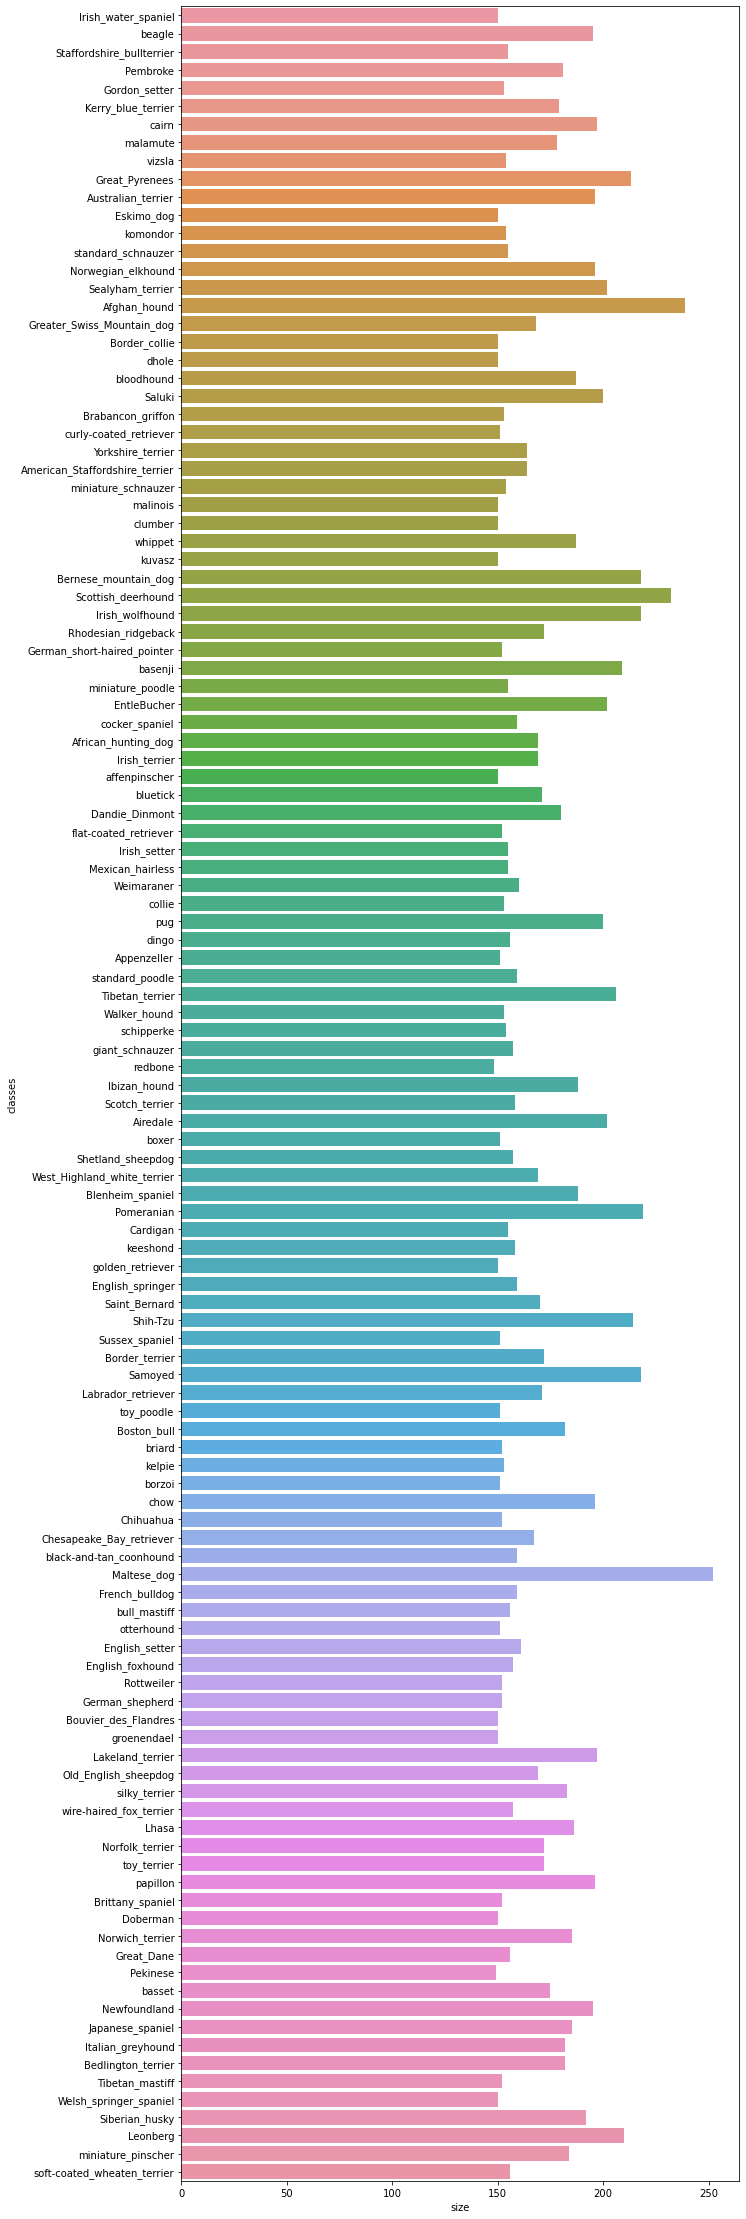

In [9]:
plt.figure(figsize=(10,40))
sns.barplot(x='size', y='classes', data=df)

Quelques images d'exemple du dataset. La méthode take d'un objet tf.data.Dataset permet d'extraire un objet tf.data.Dataset qui correspond à un batch d'images.

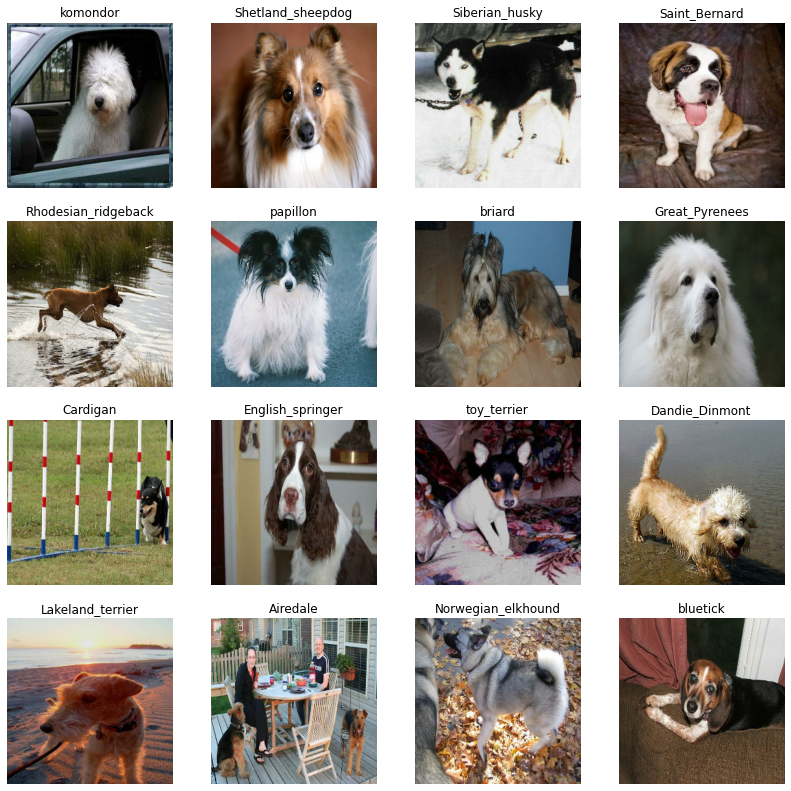

In [10]:
class_names = dataset.class_names

plt.figure(figsize=(14, 14))
for image_list, label_list in dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_list[i].numpy().astype("uint8"))
    plt.title(class_names[label_list[i]])
    plt.axis("off")

## Data Augmentation

En Deep Learning on a besoin d'un très grand nombre de données. Il existe des techniques de Data Augmentation qui permettent d'améliorer un modèle lorsque l'on a peu de données. Cela consiste à générer des modifications aléatoires dans les images pour faire comme si on avait plus d'images. Donc on ne modifie pas le nombre d'images mais on essaie d'exploiter le plus possible les images. 

Pour cela on peut utiliser la classe ImageDataGenerator de tensorflow : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Text(0.5, 1.0, 'Siberian_husky')

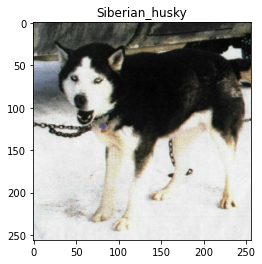

In [11]:
image = image_list[2].numpy().astype("uint8")
label = class_names[label_list[2]]

plt.imshow(image)
plt.title(label)

In [12]:
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

On va appliquer des modifications à cette image. On définit une fonction qui prend en entrée l'image à modifier et un object ImageDataGenerator qui permet de réaliser une modification.

In [13]:
def plot(images, data_generator):
    """
    Plots 4 images generated by an object of the ImageDataGenerator class.
    """
    data_generator.fit(images)
    image_iterator = data_generator.flow(images)
    
    # Plot the images given by the iterator
    fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18,18))
    for row in rows:
        row.imshow(image_iterator.next()[0].astype('int'))
        row.axis('off')
    plt.show()


Il existe plusieurs techniques pour créer de nouvelles images.

### Rotation

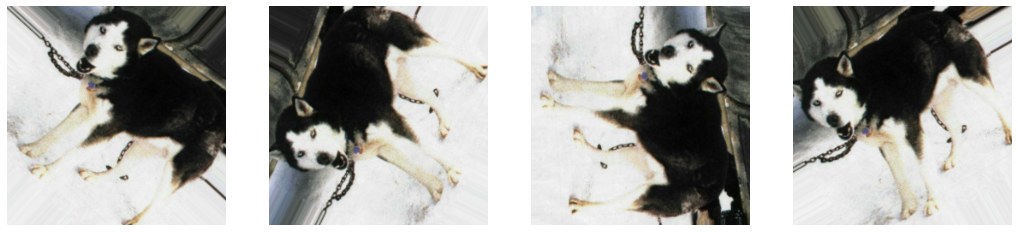

In [14]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=90)
plot(images, data_generator)

### Déplacement horizontal

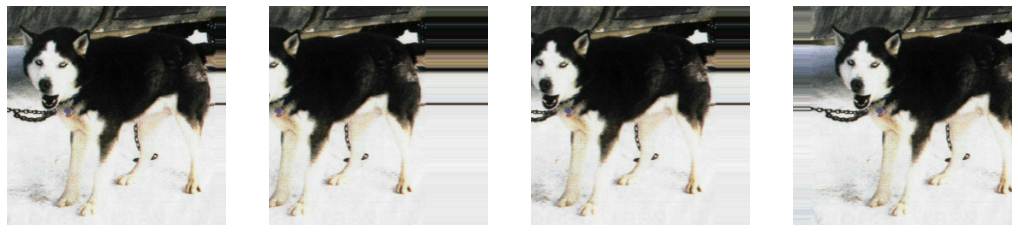

In [15]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.3)
plot(images, data_generator)

### Déplacement vertical

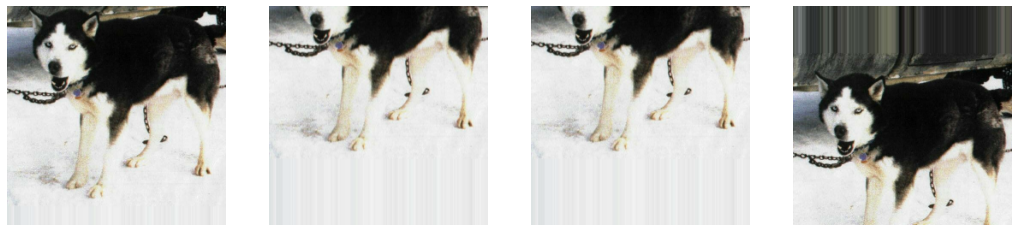

In [16]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(height_shift_range=0.3)
plot(images, data_generator)

### Luminosité

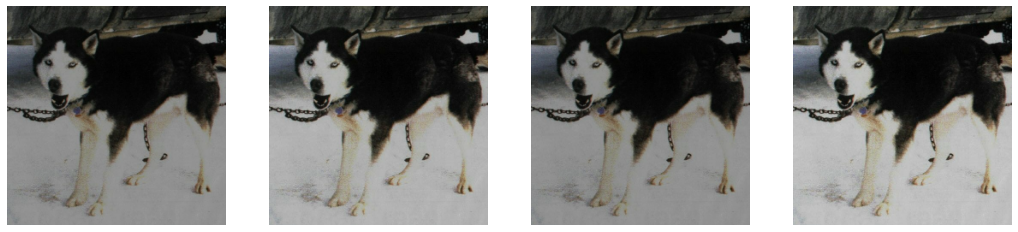

In [17]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=(0.1, 0.9))
plot(images, data_generator)

### Etirement

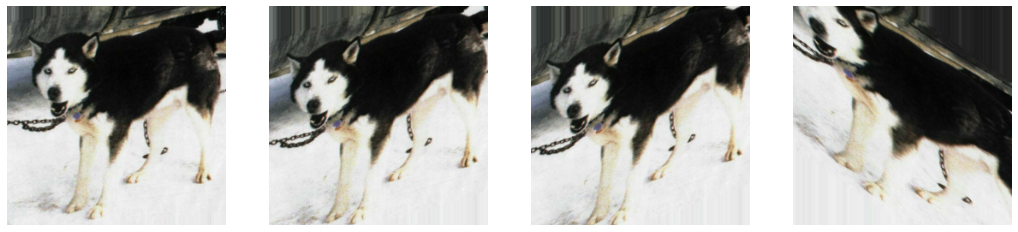

In [18]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=45.0)
plot(images, data_generator)

### Zoom

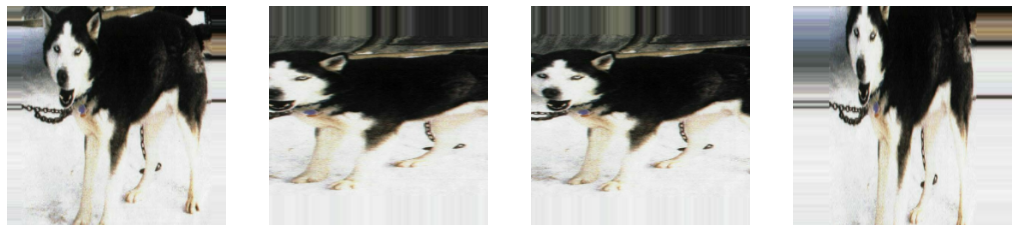

In [19]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.5, 1.5])
plot(images, data_generator)

### Channel shift

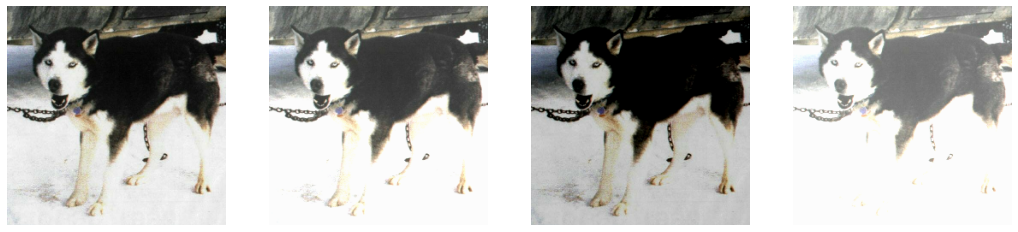

In [20]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(channel_shift_range=150.0)
plot(images, data_generator)

### Inversement horizontal

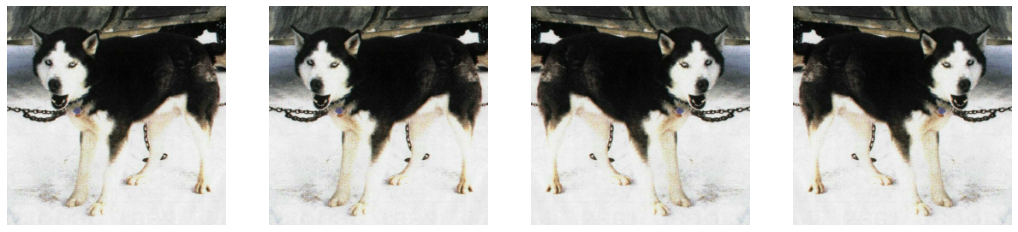

In [21]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
plot(images, data_generator)

### Inversement vertical

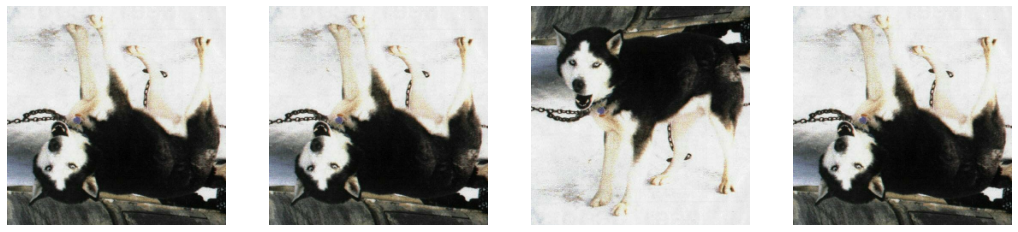

In [22]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True)
plot(images, data_generator)

## Split des données

Dans cette étude on va appliquer des transformations sur le jeu d'entrainement mais pas de transformations sur le jeu de test. On va comparer deux approches :
* Sans Data Augmentation
    * pas de transforation sur le jeu d'entraînement 
    * pas de transforation sur le jeu de validation
* Avec Data Augmentation
    * on applique des transforations sur le jeu d'entraînement 
    * pas de transforation sur le jeu de validation

In [23]:
batch_size = 32
img_height = 160
img_width = 160
img_shape = (img_height, img_width)
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

### Sans Data Augmentation

In [24]:
no_augmentation_kwargs = dict(
    rescale=1./255,
    validation_split=0.2)

In [25]:
train_datagen_no_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**no_augmentation_kwargs)

train_generator_no_augmentation = train_datagen_no_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 16508 images belonging to 120 classes.


In [26]:
validation_datagen_no_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**no_augmentation_kwargs)

validation_generator_no_augmentation = validation_datagen_no_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True)

Found 4072 images belonging to 120 classes.


### Avec Data Augmentation

In [27]:
augmentation_kwargs = dict(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=(0.1, 0.9),
    shear_range=45.0,
    zoom_range=[0.5, 1.5],
    channel_shift_range=150.0,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

In [28]:
train_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**augmentation_kwargs)

train_generator_augmentation = train_datagen_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 16508 images belonging to 120 classes.


In [29]:
validation_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**no_augmentation_kwargs)

validation_generator_augmentation = validation_datagen_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True)

Found 4072 images belonging to 120 classes.


## Model CNN simple

On va définir un réseau de neurones convolutifs (CNN) et tester 2 approches :
* Sans Data Augmentation
* Avec Data Augmentation

Les résultats seront stockés de cette façon.

In [30]:
os.makedirs('./results/CNN/data_augmentation/', exist_ok=True)
os.makedirs('./results/CNN/no_data_augmentation/', exist_ok=True)

### Sans Data Augmentation

In [31]:
model_base = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(train_generator_no_augmentation.num_classes, activation='softmax')
])

In [32]:
model_base.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [33]:
steps_per_epoch = train_generator_no_augmentation.samples // train_generator_no_augmentation.batch_size
validation_steps = validation_generator_no_augmentation.samples // validation_generator_no_augmentation.batch_size

if os.path.exists('./results/CNN/no_data_augmentation/history.npy'):
    history_base=np.load('./results/CNN/no_data_augmentation/history.npy',allow_pickle='TRUE').item()
else:
    history = model_base.fit(
    train_generator_no_augmentation,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator_no_augmentation,
    validation_steps=validation_steps)
    
    history_base = history.history
    np.save('./results/CNN/no_data_augmentation/history.npy',history_base)



#### Learning curves

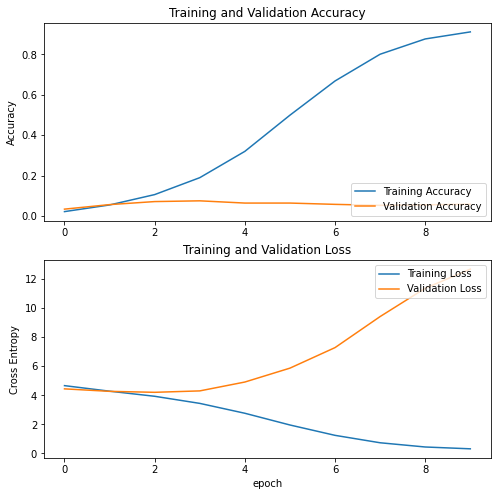

In [34]:
acc = history_base['accuracy']
val_acc = history_base['val_accuracy']

loss = history_base['loss']
val_loss = history_base['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Ce graph montre un net surapprentissage, on voit le score d'entrainement augmenter rapidement alors que le score de validation n'augmente pas. On voit aussi que l'erreur de validation augmente avec le temps ce qui montre que le modèle devient surentraîné et n'est plus capable de généraliser.

### Avec Data Augmentation

In [35]:
model_base = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(train_generator_augmentation.num_classes, activation='softmax')
])

In [36]:
model_base.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [37]:
steps_per_epoch = train_generator_augmentation.samples // train_generator_augmentation.batch_size
validation_steps = validation_generator_augmentation.samples // validation_generator_augmentation.batch_size

if os.path.exists('./results/CNN/data_augmentation/history.npy'):
    history_base=np.load('./results/CNN/data_augmentation/history.npy',allow_pickle='TRUE').item()
else:
    history = model_base.fit(
    train_generator_augmentation,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator_augmentation,
    validation_steps=validation_steps)
    
    history_base = history.history
    np.save('./results/CNN/data_augmentation/history.npy',history_base)

#### Learning curves

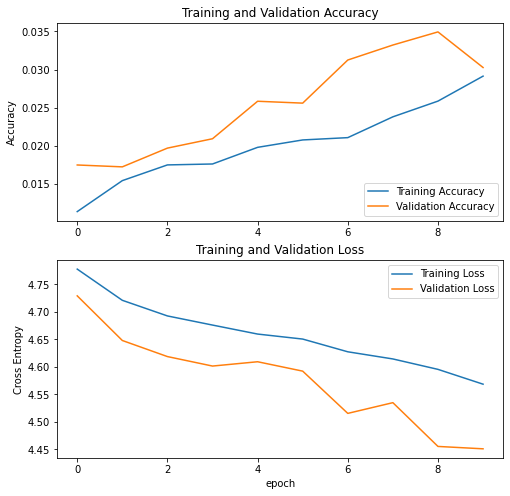

In [38]:
acc = history_base['accuracy']
val_acc = history_base['val_accuracy']

loss = history_base['loss']
val_loss = history_base['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Ce graphique est très différent du précédent. Le scores sur le jeu d'entraînement et de validation sont similaires et augmente avec le temps. Donc le modèle s'améliore avec les epochs et est capable de généraliser. En revanche les prédictions sont peu précises car seulement 2 % des prédictions sont correctes.

Pour conclure la Data Augmentation permet d'éviter le problème de surapprentissage. Cependant on constate que notre modèle n'a pas de bonnes performances. Il est possible que 20 000 images n'est pas suffisant pour obtenir un bon score. On va donc d'intéresser à une approche de transfer learning.

## Transfer learning : Features extraction

Dans cette partie on va utiliser des modèles pré-entraînés qui vont être utilisé pour faire comme du preprocessing de nos images. On va tester 5 modèles :
* EfficientNetB3
* InceptionV3
* ResNet50V2
* MobileNetV2
* VGG16

On va en même temps utiliser la data augmentation que l'on a vu précédemment.

In [39]:
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_learning_rate = 0.001
initial_epochs = 10
batch_size = 32

In [40]:
def makeGenerator(preprocessing_function):
    
    no_augmentation_kwargs = dict(
        validation_split=0.2)
    
    augmentation_kwargs = dict(
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        brightness_range=(0.1, 0.9),
        shear_range=45.0,
        zoom_range=[0.5, 1.5],
        channel_shift_range=150.0,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2)

    train_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**augmentation_kwargs, preprocessing_function=preprocessing_function)

    train_generator_augmentation = train_datagen_augmentation.flow_from_directory(
        directory='./datasets/Images',
        target_size=IMG_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True)

    validation_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**no_augmentation_kwargs, preprocessing_function=preprocessing_function)

    validation_generator_augmentation = validation_datagen_augmentation.flow_from_directory(
        directory='./datasets/Images',
        target_size=IMG_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False)
    
    return train_generator_augmentation, validation_generator_augmentation

In [41]:
def makeTFmodel(tf_model):
       
    model_kwargs = dict(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=IMG_SHAPE,
        pooling=None,
        classes=1000)
    
    base_model = tf_model(**model_kwargs)
    base_model.trainable = False
    base_model.summary()
    
    global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(120, activation='softmax')
    
    inputs = tf.keras.Input(IMG_SHAPE)
    x = base_model(inputs, training=False)
    x = global_avg_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    
    return model

In [42]:
def evaluateTFmodel(model, train_gen, validation_gen, results_path):
    
    os.makedirs(results_path, exist_ok=True)
   
    steps_per_epoch = train_gen.samples // train_gen.batch_size
    validation_steps = validation_gen.samples // validation_gen.batch_size

    if os.path.exists(results_path + 'history.npy'):
        history_dict = np.load(results_path + 'history.npy',allow_pickle='TRUE').item()
    else:
        history = model.fit(
        train_gen,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_gen,
        validation_steps=validation_steps)

        history_dict = history.history
        np.save(results_path + 'history.npy',history_dict)
        
    return history_dict

### EfficientNetB3

In [43]:
train_gen, validation_gen = makeGenerator(tf.keras.applications.efficientnet.preprocess_input)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [44]:
model_EfficientNetB3 = makeTFmodel(tf.keras.applications.EfficientNetB3)

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 160, 160, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 160, 160, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 161, 161, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [45]:
history_EfficientNetB3 = evaluateTFmodel(model_EfficientNetB3, train_gen, validation_gen, './results/TF/EfficientNetB3/')

### EfficientNetB7

In [46]:
train_gen, validation_gen = makeGenerator(tf.keras.applications.efficientnet.preprocess_input)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [47]:
model_EfficientNetB7 = makeTFmodel(tf.keras.applications.EfficientNetB7)

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 160, 160, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 160, 160, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 161, 161, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

block7b_se_expand (Conv2D)      (None, 1, 1, 3840)   618240      block7b_se_reduce[0][0]          
__________________________________________________________________________________________________
block7b_se_excite (Multiply)    (None, 5, 5, 3840)   0           block7b_activation[0][0]         
                                                                 block7b_se_expand[0][0]          
__________________________________________________________________________________________________
block7b_project_conv (Conv2D)   (None, 5, 5, 640)    2457600     block7b_se_excite[0][0]          
__________________________________________________________________________________________________
block7b_project_bn (BatchNormal (None, 5, 5, 640)    2560        block7b_project_conv[0][0]       
__________________________________________________________________________________________________
block7b_drop (Dropout)          (None, 5, 5, 640)    0           block7b_project_bn[0][0]         
__________

In [48]:
history_EfficientNetB7 = evaluateTFmodel(model_EfficientNetB7, train_gen, validation_gen, './results/TF/EfficientNetB7/')

### InceptionV3

In [49]:
train_gen, validation_gen = makeGenerator(tf.keras.applications.inception_v3.preprocess_input)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [50]:
model_InceptionV3 = makeTFmodel(tf.keras.applications.inception_v3.InceptionV3)

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 79, 79, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [51]:
history_InceptionV3 = evaluateTFmodel(model_InceptionV3, train_gen, validation_gen, './results/TF/InceptionV3/')

### ResNet50V2

In [52]:
train_gen, validation_gen = makeGenerator(tf.keras.applications.resnet_v2.preprocess_input)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [53]:
model_ResNet50V2 = makeTFmodel(tf.keras.applications.ResNet50V2)

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 82, 82, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [54]:
history_ResNet50V2 = evaluateTFmodel(model_ResNet50V2, train_gen, validation_gen, './results/TF/ResNet50V2/')

### MobileNetV2

In [55]:
train_gen, validation_gen = makeGenerator(tf.keras.applications.mobilenet_v2.preprocess_input)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [56]:
model_MobileNetV2 = makeTFmodel(tf.keras.applications.MobileNetV2)

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_9[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [57]:
history_MobileNetV2 = evaluateTFmodel(model_MobileNetV2, train_gen, validation_gen, './results/TF/MobileNetV2/')

### VGG16

In [58]:
train_gen, validation_gen = makeGenerator(tf.keras.applications.vgg16.preprocess_input)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [59]:
model_VGG16 = makeTFmodel(tf.keras.applications.VGG16)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [60]:
history_VGG16 = evaluateTFmodel(model_VGG16, train_gen, validation_gen, './results/TF/VGG16/')

### DenseNet121

In [61]:
train_gen, validation_gen = makeGenerator(tf.keras.applications.densenet.preprocess_input)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [62]:
model_DenseNet121 = makeTFmodel(tf.keras.applications.densenet.DenseNet121)

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 80, 80, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [63]:
history_DenseNet121 = evaluateTFmodel(model_DenseNet121, train_gen, validation_gen, './results/TF/DenseNet121/')

### DenseNet169

In [64]:
train_gen, validation_gen = makeGenerator(tf.keras.applications.densenet.preprocess_input)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [65]:
model_DenseNet169 = makeTFmodel(tf.keras.applications.densenet.DenseNet169)

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 166, 166, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 80, 80, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [66]:
history_DenseNet169 = evaluateTFmodel(model_DenseNet169, train_gen, validation_gen, './results/TF/DenseNet169/')

### DenseNet201

In [67]:
train_gen, validation_gen = makeGenerator(tf.keras.applications.densenet.preprocess_input)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [68]:
model_DenseNet201 = makeTFmodel(tf.keras.applications.densenet.DenseNet201)

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 166, 166, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 80, 80, 64)   9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [69]:
history_DenseNet201 = evaluateTFmodel(model_DenseNet201, train_gen, validation_gen, './results/TF/DenseNet201/')

### Comparaison

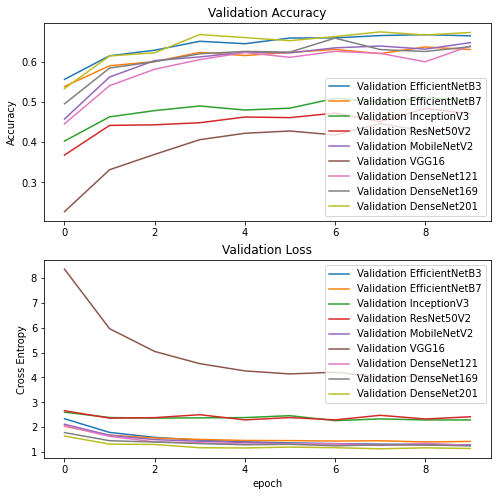

In [70]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history_EfficientNetB3['val_accuracy'], label='Validation EfficientNetB3')
plt.plot(history_EfficientNetB7['val_accuracy'], label='Validation EfficientNetB7')
plt.plot(history_InceptionV3['val_accuracy'], label='Validation InceptionV3')
plt.plot(history_ResNet50V2['val_accuracy'], label='Validation ResNet50V2')
plt.plot(history_MobileNetV2['val_accuracy'], label='Validation MobileNetV2')
plt.plot(history_VGG16['val_accuracy'], label='Validation VGG16')
plt.plot(history_DenseNet121['val_accuracy'], label='Validation DenseNet121')
plt.plot(history_DenseNet169['val_accuracy'], label='Validation DenseNet169')
plt.plot(history_DenseNet201['val_accuracy'], label='Validation DenseNet201')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history_EfficientNetB3['val_loss'], label='Validation EfficientNetB3')
plt.plot(history_EfficientNetB7['val_loss'], label='Validation EfficientNetB7')
plt.plot(history_InceptionV3['val_loss'], label='Validation InceptionV3')
plt.plot(history_ResNet50V2['val_loss'], label='Validation ResNet50V2')
plt.plot(history_MobileNetV2['val_loss'], label='Validation MobileNetV2')
plt.plot(history_VGG16['val_loss'], label='Validation VGG16')
plt.plot(history_DenseNet121['val_loss'], label='Validation DenseNet121')
plt.plot(history_DenseNet169['val_loss'], label='Validation DenseNet169')
plt.plot(history_DenseNet201['val_loss'], label='Validation DenseNet201')

plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Validation Loss')
plt.xlabel('epoch')
plt.show()

On constate que le modèle le plus intéressant pour notre application est le modèle DenseNet201. On va donc essayer d'optimiser notre modèle à partir du modèle DenseNet201.

## Optimisation avec keras tuner

Dans cette partie on va chercher à optimiser les couches fully connected ajoutées en sortie du modèle de base. On va utiliser l'archintecture suivante :
* modèle de base
* couche de dropout (dropout à optimiser)
* couche dense (nb neurones à optimiser)
* couche dense (nb neurones = nombre de classes)

Et on va également optimiser le learning rate.

### couche de dropout

Le principe d'une couche de dropout est de désactiver certains neurones (remplace les sorties par 0). C'est une technique de régularisation qui a pour principal intérêt de réduire l'overfitting.

dropout : https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

https://towardsdatascience.com/an-intuitive-explanation-to-dropout-749c7fb5395c

https://deeplylearning.fr/cours-theoriques-deep-learning/regularisation-du-reseau/

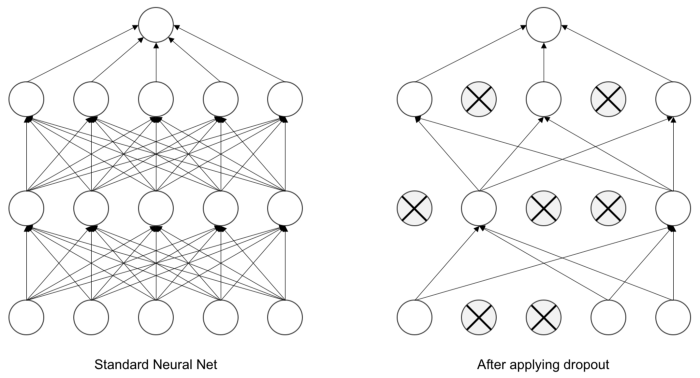

### couche dense

La couche dense aussi appelée fully connected est la plus simple des couches possibles. Chaque neurone est simplement connecté à tous les neurones de la couche précédente.

### Optimisation

In [71]:
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_learning_rate = 0.001
initial_epochs = 15
batch_size = 32

On utilise un early stopping qui va tout simplement arrêter l'entraînement du modèle si le modèle n'améliore plus son score de validation.

In [72]:
custom_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=2, 
    min_delta=0.001, 
    mode='max'
)

#### DenseNet201

In [73]:
train_gen, validation_gen = makeGenerator(tf.keras.applications.densenet.preprocess_input)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [74]:
base_DenseNet201 = tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling='avg')

base_DenseNet201.trainable = False

On définit une fonction pour créer un modèle que l'on peut faire varier en fonction de la variable hp.

In [75]:
def buildModelDenseNet201(hp):
    
    inputs = tf.keras.Input(shape=(160, 160, 3))
    x = base_DenseNet201(inputs, training=False)
    # ajout de dropout
    x = tf.keras.layers.Dropout(rate=hp.Float('dropout',
                                              min_value=0.0,
                                              max_value=0.5,
                                              default=0.25,
                                              step=0.05))(x)
    x = tf.keras.layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=1024,
                                        step=32),
                           activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

In [76]:
tuner_DenseNet201 = kerastuner.tuners.RandomSearch(
    buildModelDenseNet201,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='results/TF/keras_tuner',
    project_name='DenseNet201')


INFO:tensorflow:Reloading Oracle from existing project results/TF/keras_tuner/DenseNet201/oracle.json
INFO:tensorflow:Reloading Tuner from results/TF/keras_tuner/DenseNet201/tuner0.json


In [77]:
tuner_DenseNet201.search_space_summary()

Search space summary
Default search space size: 3
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [78]:
best_hp_DenseNet201 = tuner_DenseNet201.get_best_hyperparameters()[0]
best_model_DenseNet201 = tuner_DenseNet201.hypermodel.build(best_hp_DenseNet201)

# grab the best hyperparameters
best_hp_DenseNet201 = tuner_DenseNet201.get_best_hyperparameters(num_trials=1)[0]
print("[INFO] optimal dropout: {}".format(best_hp_DenseNet201.get("dropout")))
print("[INFO] optimal number of units in dense layer: {}".format(best_hp_DenseNet201.get("units")))
print("[INFO] optimal learning rate: {:.4f}".format(best_hp_DenseNet201.get("learning_rate")))

[INFO] optimal dropout: 0.4
[INFO] optimal number of units in dense layer: 672
[INFO] optimal learning rate: 0.0001


### Final Training

In [79]:
train_gen, validation_gen = makeGenerator(tf.keras.applications.densenet.preprocess_input)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [80]:
base_DenseNet201 = tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling='avg')

base_DenseNet201.trainable = False

In [81]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_DenseNet201(inputs, training=False)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(672, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
best_model = tf.keras.Model(inputs, outputs)
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [82]:
os.makedirs('results/TF/best_model', exist_ok=True)

steps_per_epoch = train_gen.samples // train_gen.batch_size
validation_steps = validation_gen.samples // validation_gen.batch_size

if os.path.exists('results/TF/best_model/history_before_ft.npy'):
    history_before_ft = np.load('results/TF/best_model/history_before_ft.npy',allow_pickle='TRUE').item()
    history_after_ft = np.load('results/TF/best_model/history_after_ft.npy',allow_pickle='TRUE').item()
    validation_class_indices = np.load('results/TF/best_model/validation_class_indices.npy',allow_pickle='TRUE').item()
    validation_classes = np.load('results/TF/best_model/validation_classes.npy',allow_pickle='TRUE')
    Y_pred = np.load('results/TF/best_model/Y_pred.npy',allow_pickle='TRUE')
    y_pred = np.load('results/TF/best_model/y_pred.npy',allow_pickle='TRUE')
else:
    fit_before_ft = best_model.fit(
    train_gen,
    epochs=25,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_gen,
    validation_steps=validation_steps)
    
    best_model.trainable = True
    
    fit_after_ft = best_model.fit(
    train_gen,
    initial_epoch=25,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_gen,
    validation_steps=validation_steps)
    
    history_before_ft = fit_before_ft.history
    history_after_ft = fit_after_ft.history
    np.save('results/TF/best_model/history_before_ft.npy', history_before_ft)
    np.save('results/TF/best_model/history_after_ft.npy', history_after_ft)
    best_model.save('results/TF/best_model')
    
    train_class_indices = train_gen.class_indices
    train_classes = train_gen.classes
    np.save('results/TF/best_model/train_class_indices.npy', train_class_indices)
    np.save('results/TF/best_model/train_classes.npy', train_classes)
    
    validation_class_indices = validation_gen.class_indices
    validation_classes = validation_gen.classes
    np.save('results/TF/best_model/validation_class_indices.npy', validation_class_indices)
    np.save('results/TF/best_model/validation_classes.npy', validation_classes)
    
    Y_pred = best_model.predict(validation_gen)
    y_pred = np.argmax(Y_pred, axis=1)
    np.save('results/TF/best_model/Y_pred.npy', Y_pred)
    np.save('results/TF/best_model/y_pred.npy', y_pred)


Epoch 1/25
515/515 [==============================] - 375s 466ms/step - loss: 5.1345 - accuracy: 0.0191 - val_loss: 3.7109 - val_accuracy: 0.2311
Epoch 2/25
515/515 [==============================] - 102s 198ms/step - loss: 4.3643 - accuracy: 0.0683 - val_loss: 2.5669 - val_accuracy: 0.3986
Epoch 3/25
515/515 [==============================] - 101s 196ms/step - loss: 3.9697 - accuracy: 0.1127 - val_loss: 1.9846 - val_accuracy: 0.5052
Epoch 4/25
515/515 [==============================] - 100s 194ms/step - loss: 3.7485 - accuracy: 0.1441 - val_loss: 1.7124 - val_accuracy: 0.5578
Epoch 5/25
515/515 [==============================] - 100s 194ms/step - loss: 3.6528 - accuracy: 0.1562 - val_loss: 1.5335 - val_accuracy: 0.5938
Epoch 6/25
515/515 [==============================] - 100s 195ms/step - loss: 3.5524 - accuracy: 0.1709 - val_loss: 1.4177 - val_accuracy: 0.6235
Epoch 7/25
515/515 [==============================] - 100s 194ms/step - loss: 3.4570 - accuracy: 0.1893 - val_loss: 1.3308 -

In [83]:
accuracy = sk.metrics.accuracy_score(validation_classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 71.7% 


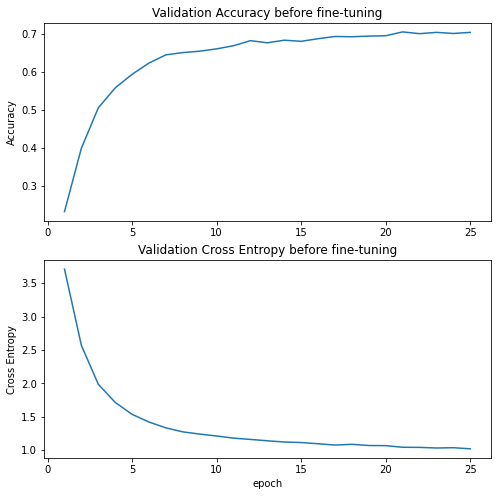

In [85]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(range(1,26), history_before_ft['val_accuracy'])

plt.ylabel('Accuracy')
plt.title('Validation Accuracy before fine-tuning')

plt.subplot(2, 1, 2)
plt.plot(range(1,26), history_before_ft['val_loss'])

plt.ylabel('Cross Entropy')
plt.title('Validation Cross Entropy before fine-tuning')
plt.xlabel('epoch')
plt.show()

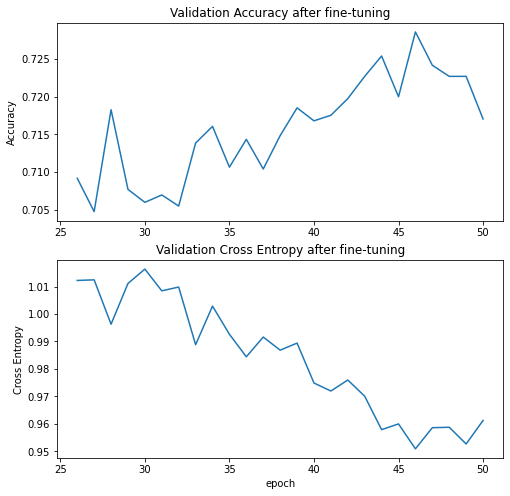

In [86]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(range(26,51), history_after_ft['val_accuracy'])

plt.ylabel('Accuracy')
plt.title('Validation Accuracy after fine-tuning')

plt.subplot(2, 1, 2)
plt.plot(range(26,51), history_after_ft['val_loss'])

plt.ylabel('Cross Entropy')
plt.title('Validation Cross Entropy after fine-tuning')
plt.xlabel('epoch')
plt.show()

#### Matrice de confusion

In [87]:
confusion_matrix = tf.math.confusion_matrix(validation_classes, y_pred, num_classes=num_classes)

In [88]:
validation_class_names = validation_class_indices.keys()

In [89]:
df_graph = pd.DataFrame(confusion_matrix.numpy(), index=validation_class_names, columns=validation_class_names)

<AxesSubplot:>

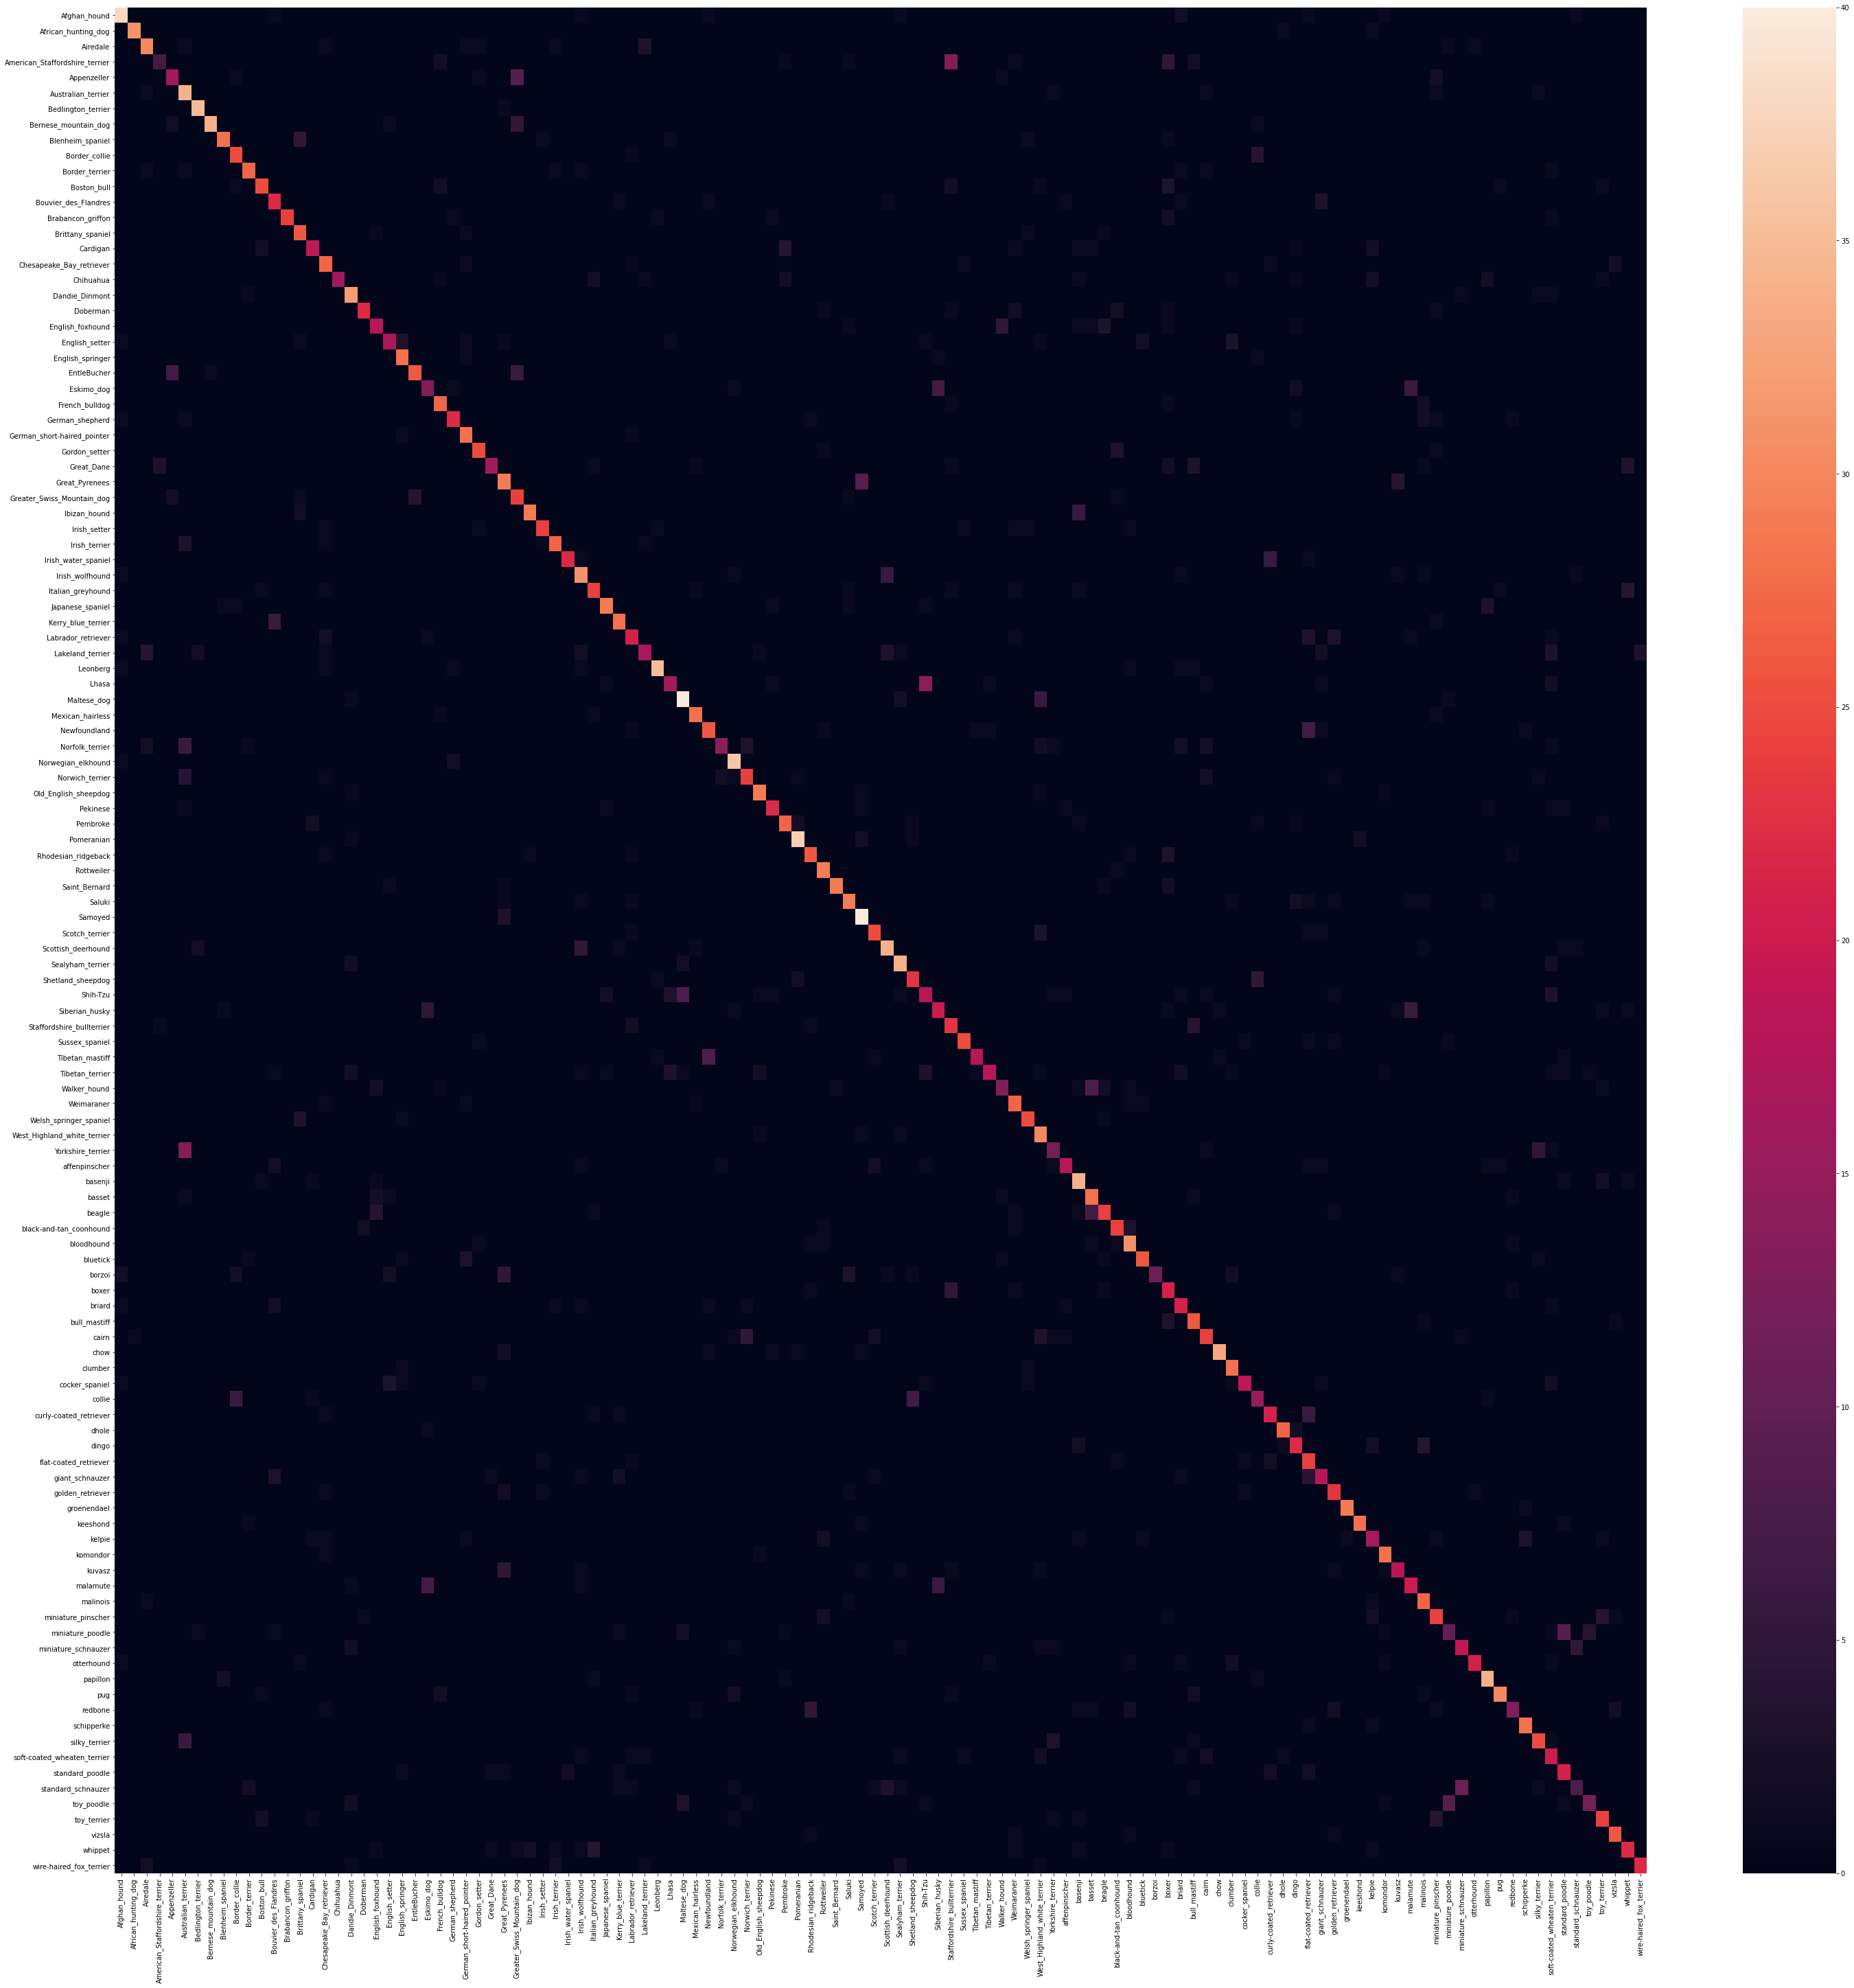

In [90]:
plt.figure(figsize=(50,50))
sns.heatmap(df_graph)